In [ ]:
import numpy as np
import pandas as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
import time
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "drive/MyDrive/project_data/project"

# Loading Data

In [ ]:
X_test = np.load(path + "/X_test.npy")
y_test = np.load(path + "/y_test.npy")
person_train_valid = np.load(path + "/person_train_valid.npy")
X_train_valid = np.load(path + "/X_train_valid.npy")
y_train_valid = np.load(path + "/y_train_valid.npy")
person_test = np.load(path + "/person_test.npy")

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


# Building Train and Validation sets

In [ ]:
# Generating the training and validation indices using random splitting
ind_valid = np.random.choice(X_train_valid.shape[0], math.floor(0.15*X_train_valid.shape[0]), replace=False)
ind_train = np.array(list(set(range(X_train_valid.shape[0])).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
(p_train, p_valid) = person_train_valid[ind_train], person_train_valid[ind_valid]

In [ ]:
print("Train Data Shape: ")
print("Input Shape:", X_train.shape)
print("Labels Shape:", y_train.shape)
print("Persons Shape:", p_train.shape)

print()

print("Validation Data Shape: ")
print("Input Shape:", X_valid.shape)
print("Labels Shape:", y_valid.shape)
print("Persons Shape:", p_valid.shape)

Train Data Shape: 
Input Shape: (1798, 22, 1000)
Labels Shape: (1798,)
Persons Shape: (1798, 1)

Validation Data Shape: 
Input Shape: (317, 22, 1000)
Labels Shape: (317,)
Persons Shape: (317, 1)


In [ ]:
# for naming consistency
p_test = person_test

Note:

Train Data: X_train, y_train, p_train

Validation Data: X_test, y_test, p_test

Test Data: X_valid, y_valid, p_valid

# Basic Data Processing

In [ ]:
def train_data_prep(X,y,p,sub_sample=2,average=2,noise=True):

    # Adjusting labels
    y -= 769

    total_X = None
    total_y = None
    total_p = None

    # Cropping the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data in time dimension (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y
    total_p = p
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging original data + adding noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    # Augmenting averaged data with noise to max pool filtered data
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    total_p = np.vstack((total_p, p))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling + optionally adding noise
    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
        # augmenting subsampled plus optionally noise added data
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        total_p = np.vstack((total_p, p))

    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    print('Shape of P:',total_p.shape)

    return total_X, total_y, total_p


def test_data_prep(X, y, p, sub_sample=2):

    #Adjusting labels
    total_y = y - 769
    total_p = p
    total_X = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X, total_y, total_p

In [ ]:
print('Train prep:')
X_train, y_train, p_train = train_data_prep(X_train, y_train, p_train)
print()
print('Validation prep:')
X_valid, y_valid, p_valid = train_data_prep(X_valid, y_valid, p_valid)
print()
print('Test prep:')
X_test, y_test, p_test = test_data_prep(X_test, y_test, p_test)

Train prep:
Shape of X after trimming: (1798, 22, 800)
Shape of X after maxpooling: (1798, 22, 400)
Shape of X after averaging+noise and concatenating: (3596, 22, 400)
Shape of X after subsampling and concatenating: (7192, 22, 400)
Shape of Y: (7192,)
Shape of P: (7192, 1)

Validation prep:
Shape of X after trimming: (317, 22, 800)
Shape of X after maxpooling: (317, 22, 400)
Shape of X after averaging+noise and concatenating: (634, 22, 400)
Shape of X after subsampling and concatenating: (1268, 22, 400)
Shape of Y: (1268,)
Shape of P: (1268, 1)

Test prep:
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)


In [ ]:
# Confirming labels look good - should be between 0 and 3
print(y_train[0])
print(y_valid[0])
print(y_test[0])

2
0
1


In [ ]:
print('Shape of all data after preprocessing')
print()

print("Train Data Shape: ")
print("Input Shape:", X_train.shape)
print("Labels Shape:", y_train.shape)
print("Persons Shape:", p_train.shape)
print()

print("Validation Data Shape: ")
print("Input Shape:", X_valid.shape)
print("Labels Shape:", y_valid.shape)
print("Persons Shape:", p_valid.shape)
print()

print("Test Data Shape: ")
print("Input Shape:", X_test.shape)
print("Labels Shape:", y_test.shape)
print("Persons Shape:", p_test.shape)
print()

Shape of all data after preprocessing

Train Data Shape: 
Input Shape: (7192, 22, 400)
Labels Shape: (7192,)
Persons Shape: (7192, 1)

Validation Data Shape: 
Input Shape: (1268, 22, 400)
Labels Shape: (1268,)
Persons Shape: (1268, 1)

Test Data Shape: 
Input Shape: (443, 22, 400)
Labels Shape: (443,)
Persons Shape: (443, 1)



# Formatting Data Correctly for RNN model

In [ ]:
# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

Shape of training labels after categorical conversion: (7192, 4)
Shape of validation labels after categorical conversion: (1268, 4)
Shape of test labels after categorical conversion: (443, 4)


In [ ]:
# Ensuring all labels look good - should look like one hot encoding
print(y_train[0])
print(y_valid[0])
print(y_test[0])

[0. 0. 1. 0.]
[1. 0. 0. 0.]
[0. 1. 0. 0.]


In [ ]:
print('Shape of all data after formatting')
print()

print("Train Data Shape: ")
print("Input Shape:", X_train.shape)
print("Labels Shape:", y_train.shape)
print("Persons Shape:", p_train.shape)
print()

print("Validation Data Shape: ")
print("Input Shape:", X_valid.shape)
print("Labels Shape:", y_valid.shape)
print("Persons Shape:", p_valid.shape)
print()

print("Test Data Shape: ")
print("Input Shape:", X_test.shape)
print("Labels Shape:", y_test.shape)
print("Persons Shape:", p_test.shape)
print()

Shape of all data after formatting

Train Data Shape: 
Input Shape: (7192, 22, 400)
Labels Shape: (7192, 4)
Persons Shape: (7192, 1)

Validation Data Shape: 
Input Shape: (1268, 22, 400)
Labels Shape: (1268, 4)
Persons Shape: (1268, 1)

Test Data Shape: 
Input Shape: (443, 22, 400)
Labels Shape: (443, 4)
Persons Shape: (443, 1)



In [ ]:
tf.config.list_physical_devices('GPU')

[]

# Generating Subject 1 Data

In [ ]:
# Getting Training, Testing, Validation indices for subject 1
subject_indices_test = np.where(p_test[:, 0] == 0)[0]
subject_indices_train = np.where(p_train[:, 0] == 0)[0]
subject_indices_valid = np.where(p_valid[:, 0] == 0)[0]

print('Subject 1 train num:', len(subject_indices_train))
print('Subject 1 valid num:', len(subject_indices_valid))
print('Subject 1 test num:', len(subject_indices_test))

Subject 1 train num: 828
Subject 1 valid num: 120
Subject 1 test num: 50


Moving on to generating train, test and validation data for subject 1

In [ ]:
# Getting train, test, and validation data for subject 1
x_subject1_train_data = X_train[subject_indices_train]
y_subject1_train_data = y_train[subject_indices_train]

x_subject1_valid_data = X_valid[subject_indices_valid]
y_subject1_valid_data = y_valid[subject_indices_valid]

x_subject1_test_data = X_test[subject_indices_test]
y_subject1_test_data = y_test[subject_indices_test]

print('Training Data for subject 1 dimensions')
print(x_subject1_train_data.shape)
print(y_subject1_train_data.shape)

print('Validation Data for subject 1 dimensions')
print(x_subject1_valid_data.shape)
print(y_subject1_valid_data.shape)

print('Testing Data for subject 1 dimensions')
print(x_subject1_test_data.shape)
print(y_subject1_test_data.shape)

Training Data for subject 1 dimensions
(828, 22, 400)
(828, 4)
Validation Data for subject 1 dimensions
(120, 22, 400)
(120, 4)
Testing Data for subject 1 dimensions
(50, 22, 400)
(50, 4)


# Helper Function to plot the accuracy and loss curves for RNN

In [ ]:
def plotAccuracyLossHistoryRNN(model_results, intro):
  print(intro)
  print()
  # Plotting accuracy trajectory
  plt.plot(model_results.history['accuracy'])
  plt.plot(model_results.history['val_accuracy'])
  plt.title('RNN Accuracy trajectory')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='lower right')
  plt.show()

  # Plotting loss trajectory
  plt.plot(model_results.history['loss'],'o')
  plt.plot(model_results.history['val_loss'],'o')
  plt.title('RNN Loss trajectory')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper right')
  plt.show()

# Optimizing classification accuracy using RNN model

In [ ]:
# Import TensorFlow
import tensorflow as tf

# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def RNNModel():
  # Building the RNN model

  model = Sequential()

  # RNN block 1 with Prascanu's regularization and gradient clipping
  model.add(SimpleRNN(units=25, activation='elu', recurrent_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(400, 22)))
  model.add(Dropout(0.25))

  # RNN block 2
  model.add(SimpleRNN(units=50, activation='elu', recurrent_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.01), return_sequences=True))
  model.add(Dropout(0.25))

  # RNN block 3
  model.add(SimpleRNN(units=100, activation='elu', recurrent_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.01), return_sequences=True))
  model.add(Dropout(0.25))

  # RNN block 4
  model.add(SimpleRNN(units=200, activation='elu', recurrent_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.01), return_sequences=True))
  model.add(Dropout(0.25))

  # Output layer with Softmax activation
  model.add(Flatten()) # Flattens the input
  model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return model

In [ ]:
model = RNNModel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 400, 25)           1200      
                                                                 
 dropout (Dropout)           (None, 400, 25)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 400, 50)           3800      
                                                                 
 dropout_1 (Dropout)         (None, 400, 50)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 400, 100)          15100     
                                                                 
 dropout_2 (Dropout)         (None, 400, 100)          0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 400, 200)          6

In [ ]:
# Compiling the model
optimizer = Adam(clipnorm=0.2, learning_rate= 1e-3) # 0.2 clipvalue for gradient clipping
model.compile(loss='categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])

In [ ]:
# Set up early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
print(x_subject1_train_data)

[[[ 5.66406250e+00 -1.36718750e+00  1.90429688e+00 ... -1.70898438e+00
    4.49218750e+00  6.25000000e+00]
  [ 9.47265625e+00  2.14843750e+00  3.75976562e+00 ... -2.78320312e+00
    4.29687500e+00  7.37304688e+00]
  [ 7.51953125e+00  1.31835938e+00  5.27343750e+00 ... -2.63671875e+00
    4.63867188e+00  6.39648438e+00]
  ...
  [-4.05273438e+00 -1.04980469e+01 -6.00585938e+00 ...  7.22656250e+00
    2.00195312e+01  2.78808594e+01]
  [-6.15234375e+00 -1.11816406e+01 -6.83593750e+00 ...  8.64257812e+00
    2.14355469e+01  2.84667969e+01]
  [-7.08007812e+00 -1.28906250e+01 -8.59375000e+00 ...  5.90820312e+00
    1.70898438e+01  2.44140625e+01]]

 [[ 1.59179688e+01  2.13867188e+01  1.78222656e+01 ...  7.81250000e-01
    1.24023438e+01  9.52148438e+00]
  [ 1.33300781e+01  1.93359375e+01  1.28417969e+01 ...  1.26953125e+00
    1.12304688e+01  8.15429688e+00]
  [ 1.48437500e+01  1.91406250e+01  1.56738281e+01 ... -2.58789062e+00
    9.27734375e+00  6.83593750e+00]
  ...
  [-8.44726562e+00 -1.9

In [ ]:
print(y_subject1_train_data)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [ ]:
x_subject1_valid_data

array([[[ 7.47070312e+00,  1.07910156e+01,  1.23046875e+01, ...,
          1.08886719e+01,  9.17968750e+00,  6.83593750e+00],
        [ 7.51953125e+00,  1.23046875e+01,  9.57031250e+00, ...,
          1.05957031e+01,  9.61914062e+00,  6.44531250e+00],
        [ 7.76367188e+00,  1.17187500e+01,  1.20117188e+01, ...,
          1.15234375e+01,  9.91210938e+00,  5.46875000e+00],
        ...,
        [ 1.22558594e+01,  1.37695312e+01,  9.86328125e+00, ...,
          6.39648438e+00,  9.42382812e+00,  1.13281250e+01],
        [ 1.24511719e+01,  1.51855469e+01,  9.61914062e+00, ...,
          6.20117188e+00,  9.32617188e+00,  1.20605469e+01],
        [ 1.12304688e+01,  1.23535156e+01,  5.95703125e+00, ...,
          3.90625000e-01,  4.34570312e+00,  8.34960938e+00]],

       [[ 1.35742188e+01,  1.38183594e+01,  5.27343750e+00, ...,
         -1.17187500e+01, -1.12304688e+01, -1.41601562e+00],
        [ 1.19628906e+01,  6.64062500e+00,  3.61328125e+00, ...,
         -7.81250000e+00, -3.41796875e

In [ ]:
y_subject1_valid_data

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],


In [ ]:
x_subject1_valid_data.shape

(120, 22, 400)

In [ ]:
X_train_reshaped_sub1 = np.swapaxes(x_subject1_train_data, 1,2)
X_train_reshaped_sub1.shape

(828, 400, 22)

In [ ]:
y_subject1_valid_data.shape

(120, 4)

In [ ]:
X_valid_reshaped_sub1 = np.swapaxes(x_subject1_valid_data, 1,2)
X_valid_reshaped_sub1.shape

(120, 400, 22)

In [ ]:
# Train the model
history = model.fit(X_train_reshaped_sub1, y_subject1_train_data,
                    epochs=20, batch_size=32, validation_data= (X_valid_reshaped_sub1, y_subject1_valid_data), verbose = True)

Epoch 1/20
26/26 [==============================] - 18s 694ms/step - loss: 7.8262 - accuracy: 0.5386 - val_loss: 8.1471 - val_accuracy: 0.3083
Epoch 2/20
26/26 [==============================] - 15s 597ms/step - loss: 3.2257 - accuracy: 0.8647 - val_loss: 7.2128 - val_accuracy: 0.4500
Epoch 3/20
26/26 [==============================] - 15s 598ms/step - loss: 2.9896 - accuracy: 0.9130 - val_loss: 11.2626 - val_accuracy: 0.3667
Epoch 4/20
26/26 [==============================] - 17s 668ms/step - loss: 2.7212 - accuracy: 0.9420 - val_loss: 14.0905 - val_accuracy: 0.3833
Epoch 5/20
26/26 [==============================] - 17s 646ms/step - loss: 2.5601 - accuracy: 0.9457 - val_loss: 13.4413 - val_accuracy: 0.3667
Epoch 6/20
26/26 [==============================] - 18s 684ms/step - loss: 2.4828 - accuracy: 0.9420 - val_loss: 16.3144 - val_accuracy: 0.3083
Epoch 7/20
26/26 [==============================] - 16s 601ms/step - loss: 2.1492 - accuracy: 0.9662 - val_loss: 14.6788 - val_accuracy: 0

Training of RNN model on subject 1 data


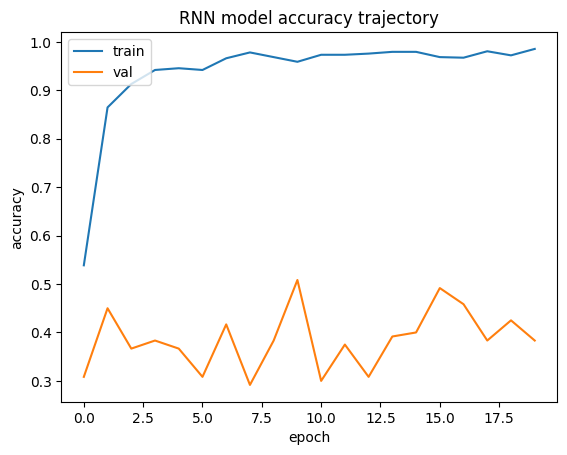

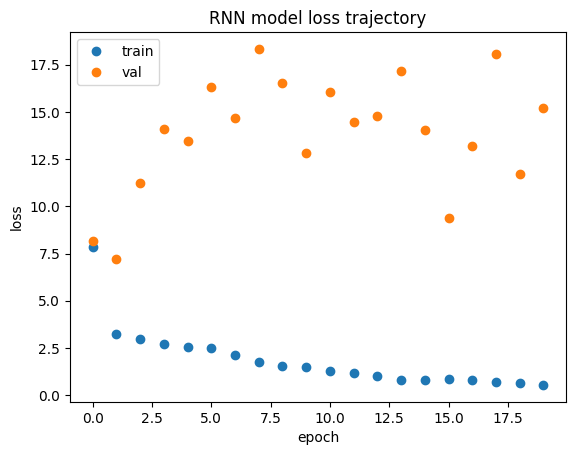

In [ ]:
# Plotting accuracy trajectory
print("Training of RNN model on subject 1 data")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('RNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('RNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_subject1_test_data_reshaped = np.swapaxes(x_subject1_test_data, 1,2)
print(x_subject1_test_data.shape)
print(x_subject1_test_data_reshaped.shape)

(50, 22, 400)
(50, 400, 22)


In [ ]:
print(y_subject1_test_data.shape)

(50, 4)


In [ ]:
## Testing the RNN model on Subject 1
rnn_acc = model.evaluate(x_subject1_test_data_reshaped, y_subject1_test_data, verbose=1)
print('Test accuracy of RNN model for Subject 1:',rnn_acc[1])

2/2 [==============================] - 0s 102ms/step - loss: 7.6431 - accuracy: 0.5200
Test accuracy of RNN model for Subject 1: 0.5199999809265137


### Training on all subjects and testing on subject 1.

In [ ]:
X_train.shape

(7192, 22, 400)

In [ ]:
y_train.shape

(7192, 4)

In [ ]:
X_train_reshaped = np.swapaxes(X_train, 1,2)
X_valid_reshaped = np.swapaxes(X_valid, 1,2)

In [ ]:
# Training the model on all subjects
rnn_model_results_all_vs_1 = model.fit(X_train_reshaped,
             y_train,
             epochs=10, batch_size = 64,
             validation_data=(X_valid_reshaped, y_valid), verbose=True)

Epoch 1/10
113/113 [==============================] - 123s 1s/step - loss: 2.2895 - accuracy: 0.5407 - val_loss: 2.2768 - val_accuracy: 0.4677
Epoch 2/10
113/113 [==============================] - 121s 1s/step - loss: 1.3182 - accuracy: 0.6828 - val_loss: 2.2255 - val_accuracy: 0.4606
Epoch 3/10
113/113 [==============================] - 120s 1s/step - loss: 1.0676 - accuracy: 0.7474 - val_loss: 2.5242 - val_accuracy: 0.4550
Epoch 4/10
113/113 [==============================] - 123s 1s/step - loss: 0.8929 - accuracy: 0.7976 - val_loss: 2.4303 - val_accuracy: 0.4858
Epoch 5/10
113/113 [==============================] - 115s 1s/step - loss: 0.7922 - accuracy: 0.8338 - val_loss: 2.6173 - val_accuracy: 0.5032
Epoch 6/10
113/113 [==============================] - 114s 1s/step - loss: 0.7519 - accuracy: 0.8479 - val_loss: 2.5482 - val_accuracy: 0.4921
Epoch 7/10
113/113 [==============================] - 115s 1s/step - loss: 0.6750 - accuracy: 0.8657 - val_loss: 2.8571 - val_accuracy: 0.4661

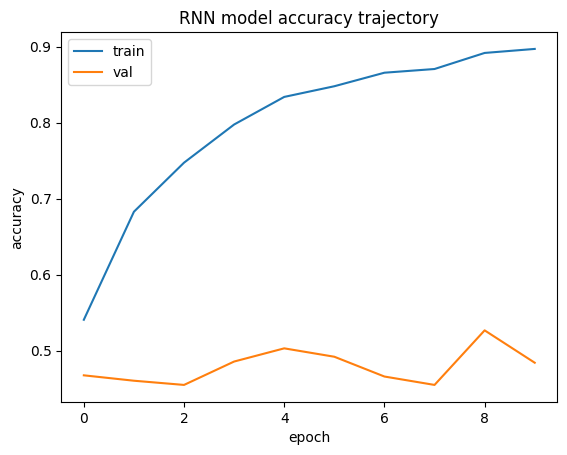

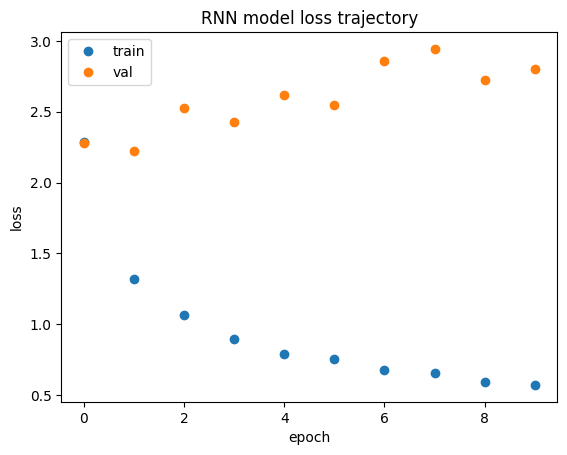

In [ ]:
# Plotting accuracy trajectory
plt.plot(rnn_model_results_all_vs_1.history['accuracy'])
plt.plot(rnn_model_results_all_vs_1.history['val_accuracy'])
plt.title('RNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(rnn_model_results_all_vs_1.history['loss'],'o')
plt.plot(rnn_model_results_all_vs_1.history['val_loss'],'o')
plt.title('RNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
## Testing the RNN model on Subject 1
rnn_score_1 = model.evaluate(x_subject1_test_data_reshaped, y_subject1_test_data, verbose=1)
print('Test accuracy of RNN model for Subject 1:',rnn_score_1[1])

2/2 [==============================] - 0s 102ms/step - loss: 3.1671 - accuracy: 0.5200
Test accuracy of RNN model for Subject 1: 0.5199999809265137


### Train on all subjects and test on all subjects

In [ ]:
# Training the model on all subjects
rnn_model_results_all_vs_all = model.fit(X_train_reshaped,y_train,
             epochs=10, batch_size = 64, validation_data=(X_valid_reshaped, y_valid), verbose=True)

Epoch 1/10
113/113 [==============================] - 175s 2s/step - loss: 0.5497 - accuracy: 0.9017 - val_loss: 2.8916 - val_accuracy: 0.5158
Epoch 2/10
113/113 [==============================] - 115s 1s/step - loss: 0.5143 - accuracy: 0.9114 - val_loss: 3.3074 - val_accuracy: 0.4645
Epoch 3/10
113/113 [==============================] - 118s 1s/step - loss: 0.5211 - accuracy: 0.9116 - val_loss: 3.0241 - val_accuracy: 0.4771
Epoch 4/10
113/113 [==============================] - 120s 1s/step - loss: 0.5060 - accuracy: 0.9100 - val_loss: 2.9701 - val_accuracy: 0.4897
Epoch 5/10
113/113 [==============================] - 120s 1s/step - loss: 0.4793 - accuracy: 0.9169 - val_loss: 3.0343 - val_accuracy: 0.5008
Epoch 6/10
113/113 [==============================] - 122s 1s/step - loss: 0.4845 - accuracy: 0.9219 - val_loss: 3.2454 - val_accuracy: 0.4921
Epoch 7/10
113/113 [==============================] - 122s 1s/step - loss: 0.4493 - accuracy: 0.9291 - val_loss: 3.2219 - val_accuracy: 0.4716

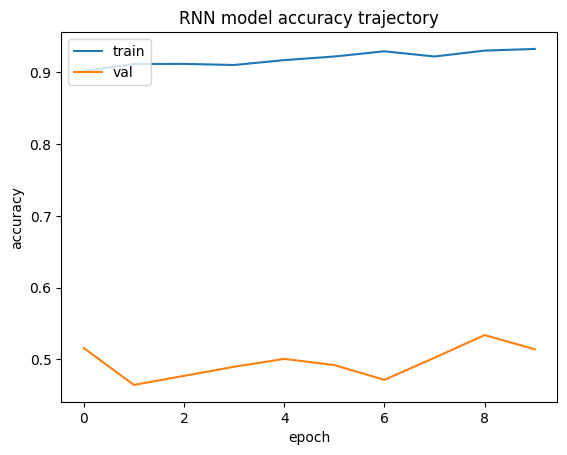

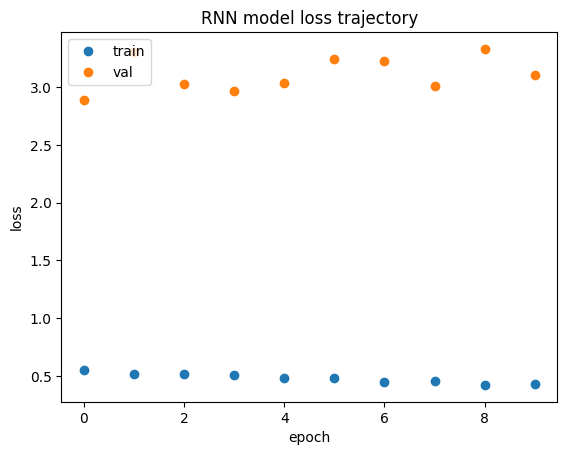

In [ ]:
# Plotting accuracy trajectory
plt.plot(rnn_model_results_all_vs_all.history['accuracy'])
plt.plot(rnn_model_results_all_vs_all.history['val_accuracy'])
plt.title('RNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(rnn_model_results_all_vs_all.history['loss'],'o')
plt.plot(rnn_model_results_all_vs_all.history['val_loss'],'o')
plt.title('RNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
X_test.shape

(443, 22, 400)

In [ ]:
X_test_reshaped = np.swapaxes(X_test, 1, 2)

In [ ]:
X_test_reshaped.shape

(443, 400, 22)

In [ ]:
## Testing the RNN model on all subjects

rnn_score_all = model.evaluate(X_test_reshaped, y_test, verbose=1)
print('Test accuracy of RNN model for all subjects:',rnn_score_all[1])

14/14 [==============================] - 2s 138ms/step - loss: 3.0686 - accuracy: 0.5305
Test accuracy of RNN model for all subjects: 0.530474066734314


# Evaluating classification accuracy as a function of time

Evaluating increasing time frames of processed data:


*   0-100
*   0-200
*   0-300
*   0-400

All the data is used in this evaluation (not particular to any subject). Also the optimized RNN model is used. A model is evaluated on each time frame for exactly 10 epochs.

In [ ]:
# Helper function to generate crops of data in time series
def generateCroppedDataSet(train_x, valid_x, test_x, begin, end):
  c_tr_x = train_x[:, begin:end, :]
  c_v_x = valid_x[:, begin:end, :]
  c_te_x = test_x[:, begin:end, :]
  return c_tr_x, c_v_x, c_te_x

In [ ]:
print(y_train.shape, y_valid.shape, y_test.shape)

(7192, 4) (1268, 4) (443, 4)


In [ ]:
def generateTensors(train, valid, test):
  # construct the dataset from the NumPy arrays
  train = tf.data.Dataset.from_tensor_slices((train, y_train))
  valid = tf.data.Dataset.from_tensor_slices((valid, y_valid))
  test = tf.data.Dataset.from_tensor_slices((test, y_test))

  # batch and shuffle
  train = train.shuffle(1024).batch(32)
  valid = valid.shuffle(1024).batch(32)
  test = test.shuffle(1024).batch(32)

  return train, valid, test

In [ ]:
# Confirming that above is working:
c_tr_x, c_v_x, c_te_x = generateCroppedDataSet(X_train, X_valid, X_test, 200, 400)
# Expected to have dimension: (datapoints, 200, 1, 22)
print(c_tr_x.shape, c_v_x.shape, c_te_x.shape)

(7192, 0, 400) (1268, 0, 400) (443, 0, 400)


In [ ]:
# Confirming labels shape
print(y_train.shape, y_valid.shape, y_test.shape)

(7192, 4) (1268, 4) (443, 4)


## Generating results for various time frames

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from tensorflow.keras.constraints import UnitNorm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

def RNNModel_time_bins(input_shape=(400, 22)):
  # Building the RNN model

  model = Sequential()

  # RNN block 1 with Prascanu's regularization and gradient clipping
  model.add(SimpleRNN(units=25, activation='elu', recurrent_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.01), return_sequences=True, input_shape=input_shape))
  model.add(Dropout(0.25))

  # RNN block 2
  model.add(SimpleRNN(units=50, activation='elu', recurrent_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.01), return_sequences=True))
  model.add(Dropout(0.25))

  # RNN block 3
  model.add(SimpleRNN(units=100, activation='elu', recurrent_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.01), return_sequences=True))
  model.add(Dropout(0.25))

  # RNN block 4
  model.add(SimpleRNN(units=200, activation='elu', recurrent_initializer='glorot_uniform',
                    kernel_regularizer=l2(0.01), return_sequences=True))
  model.add(Dropout(0.25))

  # Output layer with Softmax activation
  model.add(Flatten()) # Flattens the input
  model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

  return model

Analyzing the frame (0, 100)
(7192, 100, 22) (1268, 100, 22) (443, 100, 22)
<_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 100, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_48 (SimpleRNN)   (None, 100, 25)           1200      
                                                                 
 dropout_48 (Dropout)        (None, 100, 25)           0         
                                                                 
 simple_rnn_49 (SimpleRNN)   (None, 100, 50)     

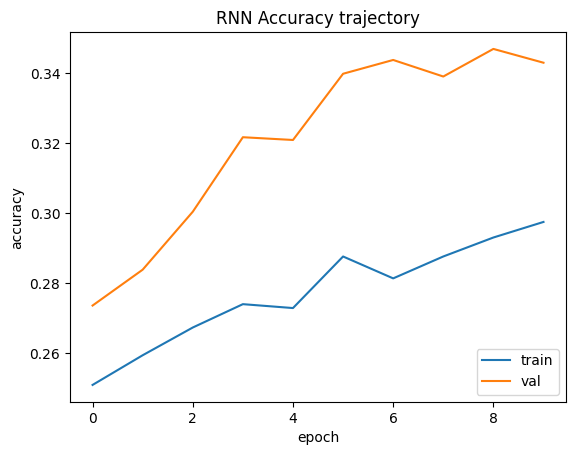

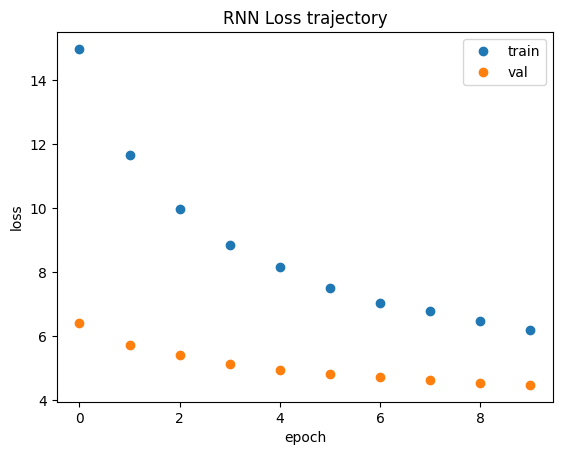

14/14 [==============================] - 1s 55ms/step - loss: 4.5383 - accuracy: 0.3183
Test accuracy of model: 0.31828442215919495


Analyzing the frame (0, 200)
(7192, 200, 22) (1268, 200, 22) (443, 200, 22)
<_BatchDataset element_spec=(TensorSpec(shape=(None, 200, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 200, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 200, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_52 (SimpleRNN)   (None, 200, 25)           1200      
                                                                 
 dropout_52 (Dropout)        (None, 200, 25)   

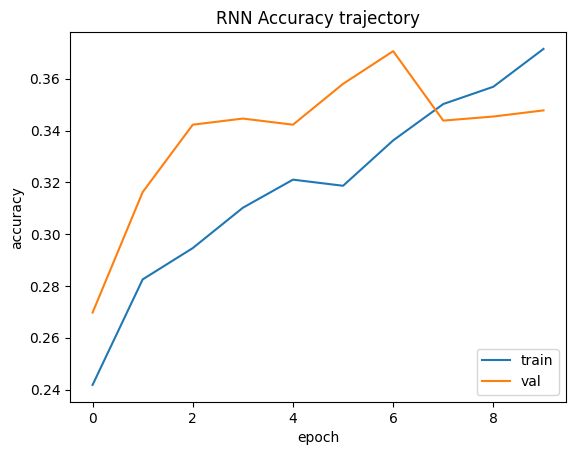

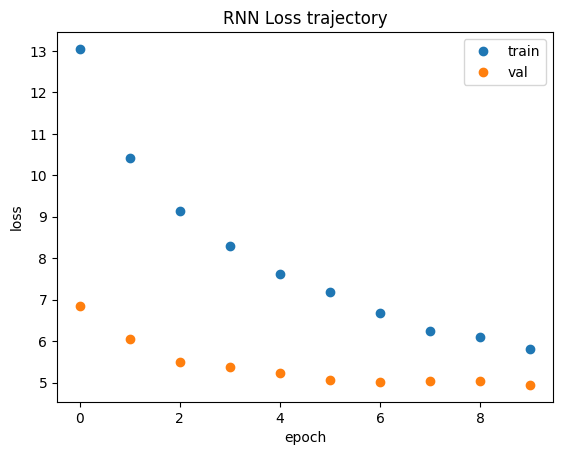

14/14 [==============================] - 1s 89ms/step - loss: 4.9890 - accuracy: 0.2980
Test accuracy of model: 0.29796838760375977


Analyzing the frame (0, 300)
(7192, 300, 22) (1268, 300, 22) (443, 300, 22)
<_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 300, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_56 (SimpleRNN)   (None, 300, 25)           1200      
                                                                 
 dropout_56 (Dropout)        (None, 300, 25)   

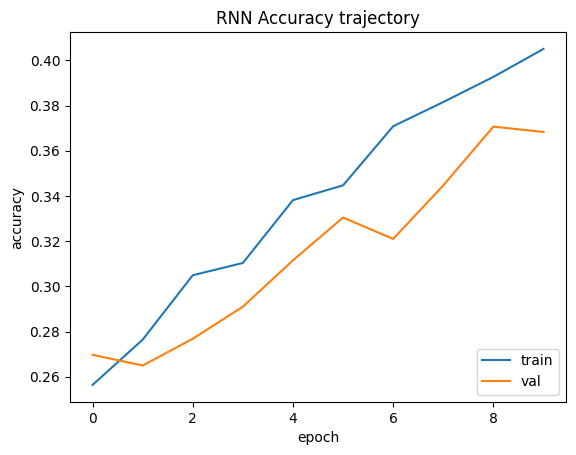

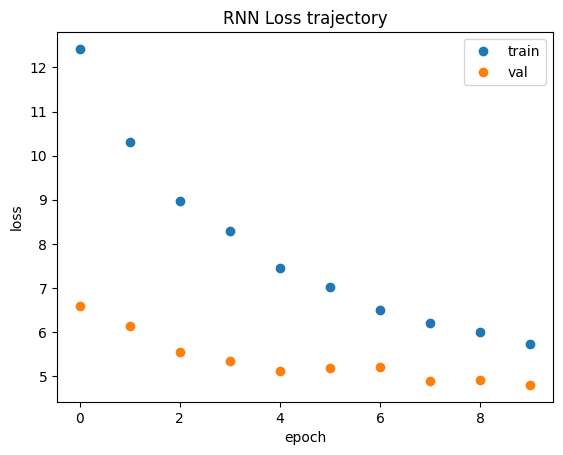

14/14 [==============================] - 1s 101ms/step - loss: 4.8069 - accuracy: 0.4041
Test accuracy of model: 0.4040631949901581


Analyzing the frame (0, 400)
(7192, 400, 22) (1268, 400, 22) (443, 400, 22)
<_BatchDataset element_spec=(TensorSpec(shape=(None, 400, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 400, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))> <_BatchDataset element_spec=(TensorSpec(shape=(None, 400, 22), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_60 (SimpleRNN)   (None, 400, 25)           1200      
                                                                 
 dropout_60 (Dropout)        (None, 400, 25)   

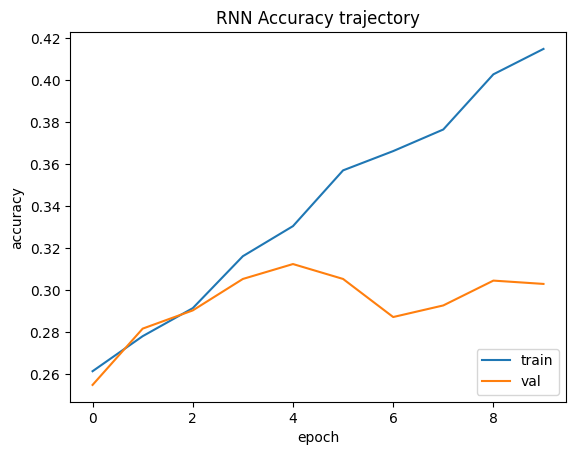

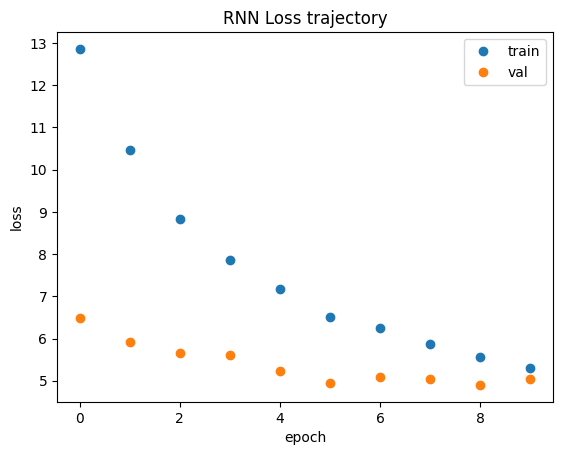

14/14 [==============================] - 2s 130ms/step - loss: 5.0314 - accuracy: 0.2980
Test accuracy of model: 0.29796838760375977




In [ ]:
test_acc = []
for end in [100, 200, 300, 400]:
    time_frame = (0, end)
    print('Analyzing the frame', time_frame)
    c_tr_x, c_v_x, c_te_x = generateCroppedDataSet(X_train_reshaped, X_valid_reshaped, X_test_reshaped, 0, end)
    print(c_tr_x.shape, c_v_x.shape, c_te_x.shape)
    train, valid, test = generateTensors(c_tr_x, c_v_x, c_te_x)
    print(train, valid, test)
    # We have data now, so we need to train a model
    c_model = RNNModel_time_bins(input_shape=(c_tr_x.shape[1], c_tr_x.shape[2]))
    c_model.summary()
    optimizer = Adam(clipnorm=0.5, learning_rate= 1e-5) # 0.5 clipvalue for gradient clipping
    c_model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    c_model_results = c_model.fit(x=train, validation_data=valid, epochs=10, verbose=True)
    plotAccuracyLossHistoryRNN(c_model_results, 'Model Training')
    score = c_model.evaluate(x=test, verbose=1)
    print('Test accuracy of model:', score[1])
    test_acc.append(score[1])
    print()
    print()


## Summary

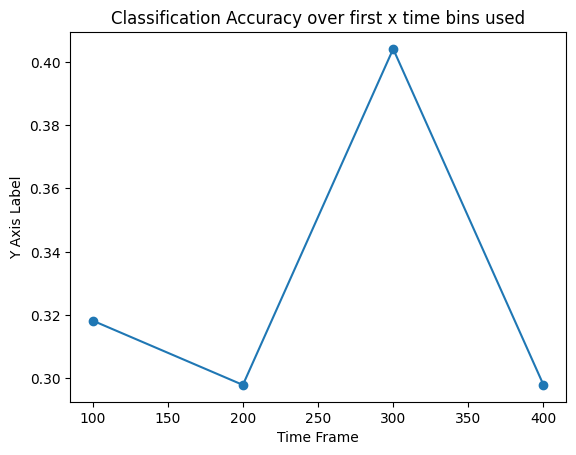

In [ ]:
x_values = [100, 200, 300, 400]
plt.plot(x_values, test_acc, marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Time Frame')
plt.ylabel('Y Axis Label')
plt.title('Classification Accuracy over first x time bins used')

# Show plot
plt.show()

The test time classification accuracy is  bad after just considering the first 200 time bins in the processed data. These 200 time bins roughly correspond to the first 400 out of 1000 time bins in the original data.